# 1. Predicting user interactions on a website

 - ### User interactions are highly time dependent, so the problem can be defined as time series analysis. There are many methods to predict interaction, but one of the methods is to use RNN

 - ### This is assumed to be a multiclass classification problem - the user interaction is predicted to belong to only one class among many classes.

### 1.1. Import

In [27]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

## The first step is to get the data. In this case, the data in the form of a csv file was downloaded from kaggle.com locally to the computer and read. The data is now a Pandas DataFrame object, which allows for easy transformations and conversions.

In [29]:
df = pd.read_csv("clicks.csv")

In [30]:
df.head()

,UserID,SessionID,Timestamp,EventType,ProductID,Amount,Outcome
0,1,1,2024-07-07 18:00:26.959902,page_view,NaN,NaN,NaN
1,1,1,2024-03-05 22:01:00.072000,page_view,NaN,NaN,NaN
2,1,1,2024-03-23 22:08:10.568453,product_view,prod_8199,NaN,NaN
3,1,1,2024-03-12 00:32:05.495638,add_to_cart,prod_4112,NaN,NaN
4,1,1,2024-02-25 22:43:01.318876,add_to_cart,prod_3354,NaN,NaN


In [31]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd

X = df.drop('EventType', axis=1)  # Dane wejściowe
y = pd.DataFrame(df['EventType'], columns=['EventType'])

le = LabelEncoder()
X['ProductID'] = le.fit_transform(X['ProductID'].astype(str)) 
X['Outcome'] = le.fit_transform(X['ProductID'].astype(str)) 
X["Timestamp"] = pd.to_datetime(X["Timestamp"])
X["Timestamp"] = X["Timestamp"].astype("int64") // 10**9


In [32]:
import pandas as pd
import torch
import torch.nn.functional as F
import numpy as np

# Załóżmy, że twój DataFrame nazywa się 'y' i ma kolumnę 'EventType'
# Przykładowe dane z listami

# Konwersja list na krotki
y['EventType'] = y['EventType'].apply(lambda x: tuple(x) if isinstance(x, list) else x)

event_types = y['EventType'].values

unique_event_types = np.unique(event_types)
event_type_to_index = {event_type: index for index, event_type in enumerate(unique_event_types)}
print(event_type_to_index)
event_indices = torch.tensor([event_type_to_index[event_type] for event_type in event_types])

encoded_tensor = F.one_hot(event_indices, num_classes=len(unique_event_types))
encoded_list = encoded_tensor.tolist()
print(encoded_tensor.size())
y['EventType'] = encoded_list


print(unique_event_types)
y.head()

{'add_to_cart': 0, 'click': 1, 'login': 2, 'logout': 3, 'page_view': 4, 'product_view': 5, 'purchase': 6}
torch.Size([74817, 7])
['add_to_cart' 'click' 'login' 'logout' 'page_view' 'product_view'
 'purchase']


,EventType
0,"[0, 0, 0, 0, 1, 0, 0]"
1,"[0, 0, 0, 0, 1, 0, 0]"
2,"[0, 0, 0, 0, 0, 1, 0]"
3,"[1, 0, 0, 0, 0, 0, 0]"
4,"[1, 0, 0, 0, 0, 0, 0]"


In [33]:
from sklearn.preprocessing import StandardScaler
# Inicjalizacja scalerów
timestamp_scaler = StandardScaler()
product_id_scaler = StandardScaler()
amount_scaler = StandardScaler()
outcome_scaler = StandardScaler()

# Skalowanie danych
X['Timestamp'] = timestamp_scaler.fit_transform(X[['Timestamp']])
X['ProductID'] = product_id_scaler.fit_transform(X[['ProductID']])
X['Amount'] = amount_scaler.fit_transform(X[['Amount']])
X['Outcome'] = outcome_scaler.fit_transform(X[['Outcome']])
X.fillna(0, inplace=True)

In [34]:
X.head()

,UserID,SessionID,Timestamp,ProductID,Amount,Outcome
0,1,1,1.446026,-0.690755,0.0,-0.691486
1,1,1,-0.639453,-0.690755,0.0,-0.691486
2,1,1,-0.336230,1.875891,0.0,1.752337
3,1,1,-0.536640,0.419919,0.0,0.135941
4,1,1,-0.790532,0.151597,0.0,-0.162577


In [35]:
y.head()

,EventType
0,"[0, 0, 0, 0, 1, 0, 0]"
1,"[0, 0, 0, 0, 1, 0, 0]"
2,"[0, 0, 0, 0, 0, 1, 0]"
3,"[1, 0, 0, 0, 0, 0, 0]"
4,"[1, 0, 0, 0, 0, 0, 0]"


In [36]:
X.describe()

,UserID,SessionID,Timestamp,ProductID,Amount,Outcome
count,74817.000000,74817.000000,7.481700e+04,7.481700e+04,7.481700e+04,7.481700e+04
mean,500.740741,5.509777,1.839517e-14,-1.106409e-17,-4.252316e-17,2.303041e-18
std,288.945183,2.869337,1.000007e+00,1.000007e+00,3.778584e-01,1.000007e+00
min,1.000000,1.000000,-1.732713e+00,-6.907549e-01,-1.734219e+00,-6.914860e-01
25%,251.000000,3.000000,-8.705337e-01,-6.907549e-01,0.000000e+00,-6.914860e-01
50%,501.000000,6.000000,2.499983e-03,-6.907549e-01,0.000000e+00,-6.914860e-01
75%,751.000000,8.000000,8.660787e-01,6.618475e-01,0.000000e+00,6.681470e-01
max,1000.000000,10.000000,1.726858e+00,2.515536e+00,1.725367e+00,2.512369e+00


In [37]:
import torch
from torch.utils.data import Dataset
import pandas as pd

class EventDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = torch.tensor(self.data.iloc[idx].values, dtype=torch.float32)  # Konwersja na tensor
        label = torch.tensor(self.labels.iloc[idx], dtype=torch.float32)  # Konwersja na tensor
        return sample, label


In [38]:
# Podział danych na zbiór treningowy i testowy
input_train, input_test, target_train, target_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Utworzenie Dataset i DataLoader dla zbioru treningowego i testowego
train_dataset = EventDataset(input_train, target_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = EventDataset(input_test, target_test)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [39]:
input_test.head()

,UserID,SessionID,Timestamp,ProductID,Amount,Outcome
30862,414,3,-0.030110,-0.690755,0.000000,-0.691486
21696,292,1,1.601830,-0.690755,0.000000,-0.691486
54163,725,3,-0.489833,-0.314299,0.316822,-0.679399
14463,193,9,0.747261,-0.337026,0.000000,2.498817
63524,850,7,0.798924,-0.690755,0.000000,-0.691486


In [40]:
input_test.describe()

,UserID,SessionID,Timestamp,ProductID,Amount,Outcome
count,14964.000000,14964.000000,14964.000000,14964.000000,14964.000000,14964.000000
mean,499.919407,5.512563,-0.007671,0.003390,-0.002384,0.005651
std,287.330171,2.877092,0.994691,1.001173,0.379604,1.001542
min,1.000000,1.000000,-1.732187,-0.690755,-1.728077,-0.691486
25%,253.000000,3.000000,-0.872808,-0.690755,0.000000,-0.691486
50%,499.000000,6.000000,-0.014781,-0.690755,0.000000,-0.691486
75%,746.000000,8.000000,0.847633,0.667346,0.000000,0.678586
max,1000.000000,10.000000,1.726773,2.515169,1.723911,2.512369


In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np

# Definicja modelu RNN
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)  # Stan początkowy
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])  # Ostatni krok sekwencji
        return out


In [42]:
print(input_train.shape[1])

6


In [43]:
input_train.head()

,UserID,SessionID,Timestamp,ProductID,Amount,Outcome
44526,595,9,0.159930,1.370406,0.029208,1.190829
15644,209,10,1.023971,1.589975,0.000000,1.434772
69485,931,3,-0.856790,1.165866,-1.718161,0.963735
21659,291,5,1.423285,-0.690755,0.000000,-0.691486
29026,389,10,-0.614555,-0.488414,0.000000,1.148707


In [44]:
input_size = input_train.shape[1]  # Liczba cech wejściowych
hidden_size = 64  # Liczba neuronów w warstwie ukrytej
output_size = 7  # Liczba klas
num_layers = 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = RNNModel(input_size, hidden_size, output_size, num_layers).to(device)
criterion = nn.CrossEntropyLoss()  # Ponieważ targety są klasyfikacją wieloklasową
optimizer = optim.Adam(model.parameters(), lr=0.001)


C:\Users\Wojci\AppData\Local\Temp\ipykernel_12208\3945688704.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = torch.tensor(self.labels.iloc[idx], dtype=torch.float32)  # Konwersja na tensor


Epoch 1, Loss: 1.4996, Accuracy: 26.16%
Epoch 2, Loss: 1.3299, Accuracy: 27.85%
Epoch 3, Loss: 1.3082, Accuracy: 28.73%
Epoch 4, Loss: 1.3044, Accuracy: 28.59%
Epoch 5, Loss: 1.2956, Accuracy: 28.92%
Epoch 6, Loss: 1.2883, Accuracy: 29.18%
Epoch 7, Loss: 1.2606, Accuracy: 33.50%
Epoch 8, Loss: 1.1532, Accuracy: 38.94%
Epoch 9, Loss: 1.1045, Accuracy: 40.51%
Epoch 10, Loss: 1.0877, Accuracy: 40.88%


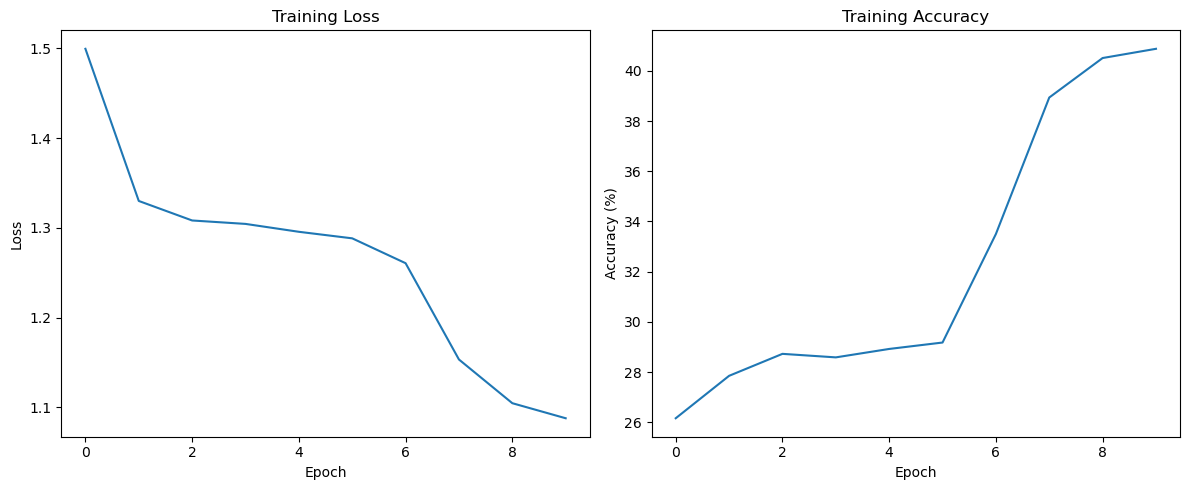

In [45]:
import matplotlib.pyplot as plt
num_epochs = 10
#input_train = input_train.reset_index(drop=True)
#input_test = input_test.reset_index(drop=True)
#target_train = target_train.reset_index(drop=True)
#target_test = target_test.reset_index(drop=True)


losses = []
accuracies = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for inputs, targets in train_dataloader:
        inputs_reshaped = inputs.unsqueeze(1)
        targets = targets.squeeze(1)

        optimizer.zero_grad()
        outputs = model(inputs_reshaped)

        if targets.dim() > 1:
            targets = torch.argmax(targets, dim=1)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Obliczanie dokładności
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

    epoch_loss = total_loss / len(train_dataloader)
    epoch_accuracy = 100 * correct / total

    losses.append(epoch_loss)
    accuracies.append(epoch_accuracy)

    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

# Wykres strat
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Wykres dokładności
plt.subplot(1, 2, 2)
plt.plot(accuracies)
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

plt.tight_layout()
plt.show()


C:\Users\Wojci\AppData\Local\Temp\ipykernel_12208\3945688704.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = torch.tensor(self.labels.iloc[idx], dtype=torch.float32)  # Konwersja na tensor


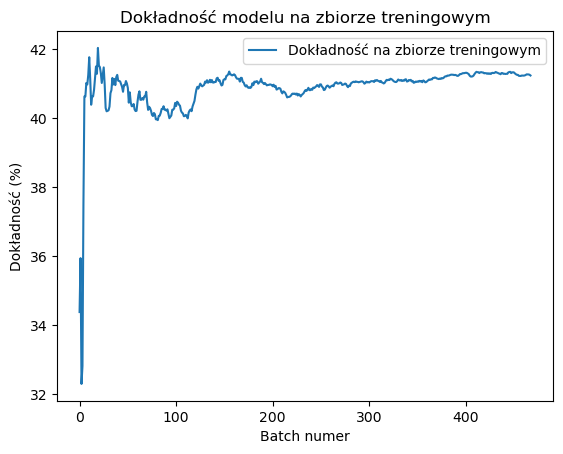

In [81]:
import torch
import matplotlib.pyplot as plt

# Załóżmy, że masz już zdefiniowany model, np. `model`
# I masz również odpowiednie metody do obliczania dokładności

# Upewnij się, że model jest w trybie ewaluacyjnym
model.eval()

# Inicjalizacja zmiennych do śledzenia dokładności
correct = 0
total = 0
accuracies = []

# Przechodzimy przez dane treningowe
with torch.no_grad():  # Wyłącz gradienty podczas ewaluacji, by oszczędzać pamięć
    for inputs, targets in test_dataloader:
        # Przenieś dane do odpowiedniego urządzenia (CPU/GPU)
        inputs, targets = inputs.to(device), targets.to(device)
        inputs_reshaped = inputs.unsqueeze(1)
        targets = targets.squeeze(1)
        # Przewidywanie
        outputs = model(inputs_reshaped)
         # Zakładając, że 'outputs' ma rozmiar [batch_size, num_classes], wybieramy klasę o największym prawdopodobieństwie
        _, predicted = torch.max(outputs, 1)
        
        # Jeśli targets są w formacie one-hot, musimy przekonwertować je na indeksy klas
        targets = torch.argmax(targets, dim=1)  # Konwertujemy one-hot na etykiety klas

        # Obliczanie liczby poprawnych przewidywań
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

        # Obliczanie dokładności dla tego batcha
        accuracy = 100 * correct / total
        accuracies.append(accuracy)

# Wyświetlenie wykresu
plt.plot(accuracies, label="Dokładność na zbiorze treningowym")
plt.xlabel("Batch numer")
plt.ylabel("Dokładność (%)")
plt.title("Dokładność modelu na zbiorze treningowym")
plt.legend()
plt.show()
